In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [2]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [3]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1.030000e+03,1.030000e+03
mean,3779.433654,-0.990423,-0.000002,-0.000161,-0.000001,0.000001,7.629146e-07,1.496077e-07
std,2172.569576,0.001019,0.003207,0.000692,0.002136,0.006600,1.426902e-03,2.166866e-07
min,21.909760,-0.991664,-0.004520,-0.001118,-0.003245,-0.009031,-2.043062e-03,-2.219465e-07
25%,1900.671750,-0.991455,-0.003224,-0.000846,-0.001973,-0.006496,-1.434597e-03,-2.287116e-08
50%,3779.433500,-0.990581,-0.000023,-0.000212,-0.000007,-0.000397,9.653665e-06,8.666964e-08
75%,5658.195250,-0.989402,0.003220,0.000523,0.001975,0.006452,1.439907e-03,3.219879e-07
max,7536.958000,-0.988842,0.004520,0.000896,0.003245,0.009926,2.048094e-03,7.003602e-07


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

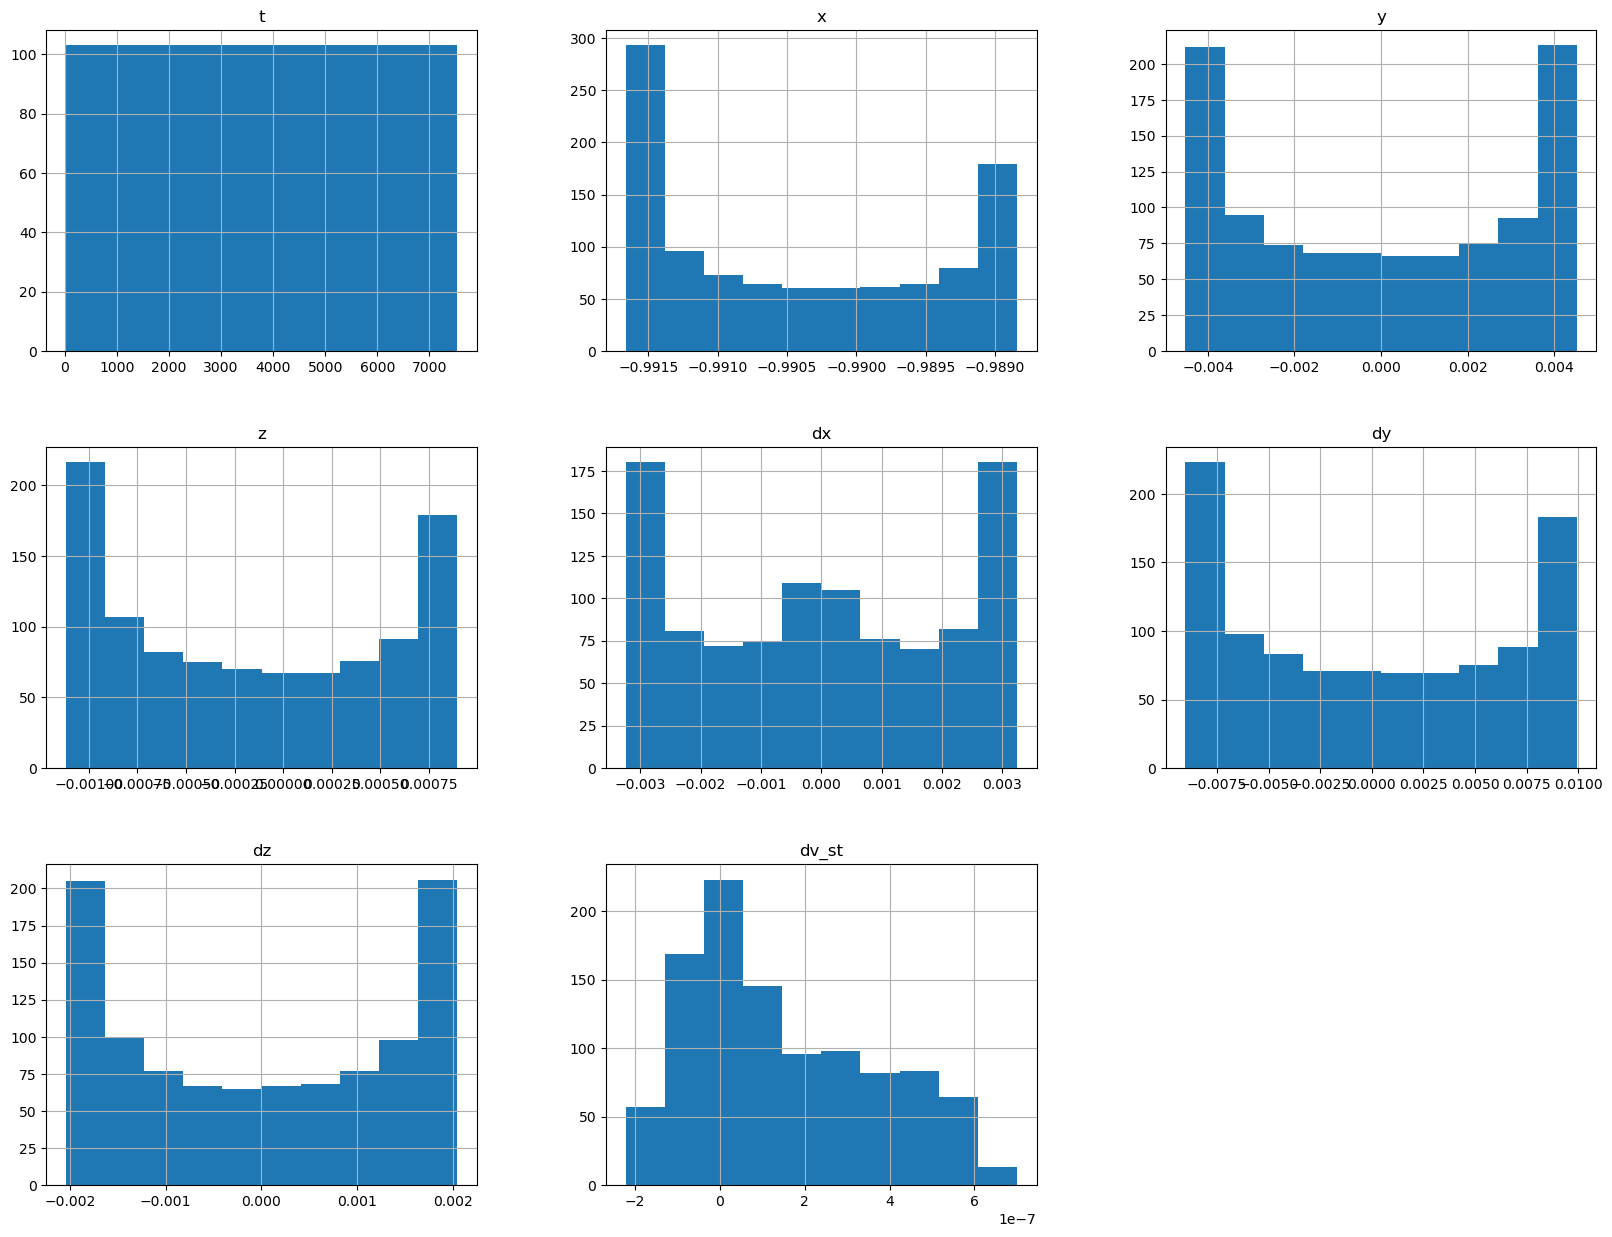

In [4]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

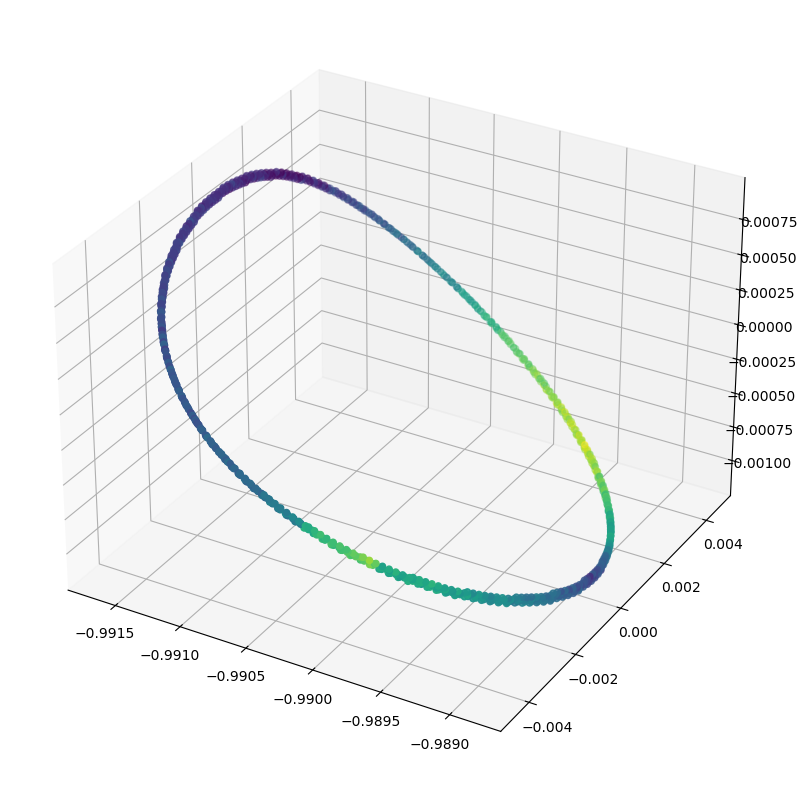

In [5]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [6]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t", "dx", "dy", "dz"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
x        0.638064
y        0.198891
angle   -0.052834
z       -0.700144
Name: dv_st, dtype: float64

array([[<Axes: xlabel='angle', ylabel='angle'>,
        <Axes: xlabel='x', ylabel='angle'>,
        <Axes: xlabel='y', ylabel='angle'>,
        <Axes: xlabel='z', ylabel='angle'>,
        <Axes: xlabel='dv_st', ylabel='angle'>],
       [<Axes: xlabel='angle', ylabel='x'>,
        <Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='y', ylabel='x'>,
        <Axes: xlabel='z', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='angle', ylabel='y'>,
        <Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='y', ylabel='y'>,
        <Axes: xlabel='z', ylabel='y'>,
        <Axes: xlabel='dv_st', ylabel='y'>],
       [<Axes: xlabel='angle', ylabel='z'>,
        <Axes: xlabel='x', ylabel='z'>, <Axes: xlabel='y', ylabel='z'>,
        <Axes: xlabel='z', ylabel='z'>,
        <Axes: xlabel='dv_st', ylabel='z'>],
       [<Axes: xlabel='angle', ylabel='dv_st'>,
        <Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='y', ylabel='dv_st'>,
        <Axes: xlabel='z', ylabe

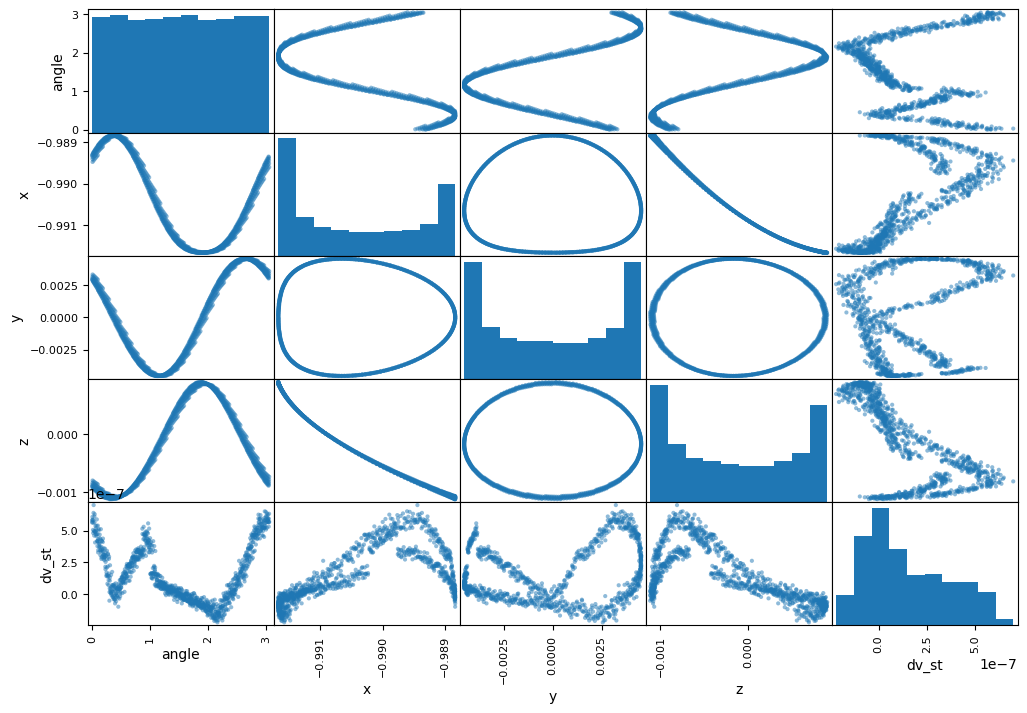

In [7]:
attributes = ["angle", "x", "y", "z", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [8]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,angle
0,-0.988935,-0.001338,-0.001081,0.495174
1,-0.991622,-0.001865,0.000796,1.679971
2,-0.989867,0.003980,-0.000637,2.864777
3,-0.990210,-0.004343,-0.000449,0.990348
4,-0.991548,0.002750,0.000664,2.175144


In [9]:
## Create Train/Test/Validation Sets

In [10]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(618, 4)
(206, 4)
(206, 4)


,x,y,z,angle
719,-0.991658,-0.000266,0.000867,1.901558
753,-0.991297,0.003878,0.000343,2.415203
112,-0.991601,-0.002172,0.000754,1.646010
205,-0.991627,-0.001720,0.000804,1.700603
740,-0.991459,0.003285,0.000526,2.308228


In [11]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.00187843, 0.47031538, 0.98745681, 0.62244532],
       [0.12989545, 0.92889783, 0.72666794, 0.79100654],
       [0.02197413, 0.25945768, 0.93098085, 0.53858295],
       [0.01279461, 0.30944747, 0.95612823, 0.55649872],
       [0.07226652, 0.86327378, 0.81750646, 0.75590082]])

In [12]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)
y_test_scaled = scaler.transform(y_test)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [14]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.13780905152163908

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [15]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [16]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.24748786059995015, 0.25994267416684713, 0.2636445555475202, 0.8013242232762703, 0.13063929818573367, 0.45334908658909234, 0.0828173534898966, 0.07068722367516145, 0.039117464938723784, 0.3971185506946876]
Labels: [array([0.26105215]), array([0.27427291]), array([0.27608219]), array([0.92226588]), array([0.10661096]), array([0.54240374]), array([0.04675473]), array([0.10944711]), array([0.09567403]), array([0.43268796])]


In [17]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.01586430848898967

## Polynomial Regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
#print(maneuvers_pred_poly[0])

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.05292869397956683

## SVM Regression

In [20]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.08017413602089746

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [21]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, X_train_scaled, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
tree_rmse_scores = -scores

In [22]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [0.05903753 0.04973531 0.05217681 0.05746034 0.05837386]
Mean: 0.05535676839108876
Standard deviation: 0.0037091449688904554
